<a href="https://colab.research.google.com/github/chalsai/Introduction-To-Computer-Vision/blob/main/Week_9_Friday_Age_Detection__Computer_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='#2F4F4F'>Computer Vision Project</font>

## <font color='#2F4F4F'>Step 1. Business Understanding </font>

### a) Specifying the Research Question

The supermarket chain would like to explore whether Data Science can help them adhere to
alcohol laws by making sure they do not sell alcohol to people underage. You are asked to
conduct that evaluation, so as you set to work, keep the following in mind:

● The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.

● Computer vision methods can be used to determine the age of a person from a photo.

● The task then is to build and evaluate a model for verifying people's age.
To start working on the task, you'll have a set of photographs of people with their ages indicated.


### b) Defining the Metric for Success

The task then is to build and evaluate a model for verifying people's age.


### d) Project Instrusctions

● Before getting your hands dirty with the project, let's think of the Good Seed supermarket task in detail.
Imagine your manager wants to check your understanding of the task.
Pass this quiz to verify your understanding of the project statement.

● Perform exploratory data analysis to get an overall impression of the dataset.

● Train and evaluate the model (it needs to be done on the GPU platform).

● Combine your code, output, and findings (from the previous points) in the final notebook.

● Make conclusions of the model evaluation, add them to the notebook.



## <font color='#2F4F4F'>Step 2. Data Importation</font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
# Importing our dataset
# ---
# Loading our Training Dataset
# -The dataset is stored in the /datasets/faces/ folder, It contains:

#The final_files folder with 7.6k photos
#The labels.csv file with labels, with two columns: file_name and real_age

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Given the fact that the number of image files is rather high, we will avoid reading them all at once, which would greatly consume computational resources. instead i will build a generator with the ImageDataGenerator generator.

In [ ]:

import warnings
warnings.filterwarnings('ignore')


labels = pd.read_csv('/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/content/drive/MyDrive/Colab Notebooks/Images_ComputerVision/images',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
features, target = next(train_gen_flow)
print(target.shape)
features.shape

(32,)


(32, 224, 224, 3)

## <font color='#2F4F4F'>Step 3. EDA</font>

In [ ]:
def pre_exam(df):
    print('head:')
    display(df.head(3))
    print('info:')
    display(df.info())
    print('describe:')
    display(df.describe())
    print('duplicate: ',df.duplicated().sum())
    print('isna:')
    display(df.isna().sum())
    print('total missing: {:.2%}'.format((df.isna().sum().sum())/len(df)))

In [ ]:
pre_exam(labels)

head:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

describe:


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


duplicate:  0
isna:


file_name    0
real_age     0
dtype: int64

total missing: 0.00%


The data contents 7591 records and varias from one year old to 100 years old, the mean is 31, no missing values and no duplicates

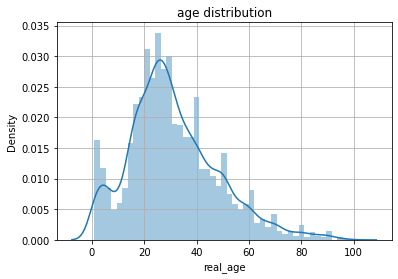

In [ ]:
#Age Distribution
sns.distplot(labels.real_age, kde=True)
plt.grid(True)
plt.title('age distribution');

The age distribution is like a gamma distribution, which is  good for our purposes of  making sure we dont sell alcohol to underage persons. Although the mass is between 20-40 which are not underage.

We have outaires like a one year old baby or a 100 year old elderly. They are not so relevant because the chances of them coming alone to buy alcohol is low.So we shall ignore them for now. 

## Ploting Images

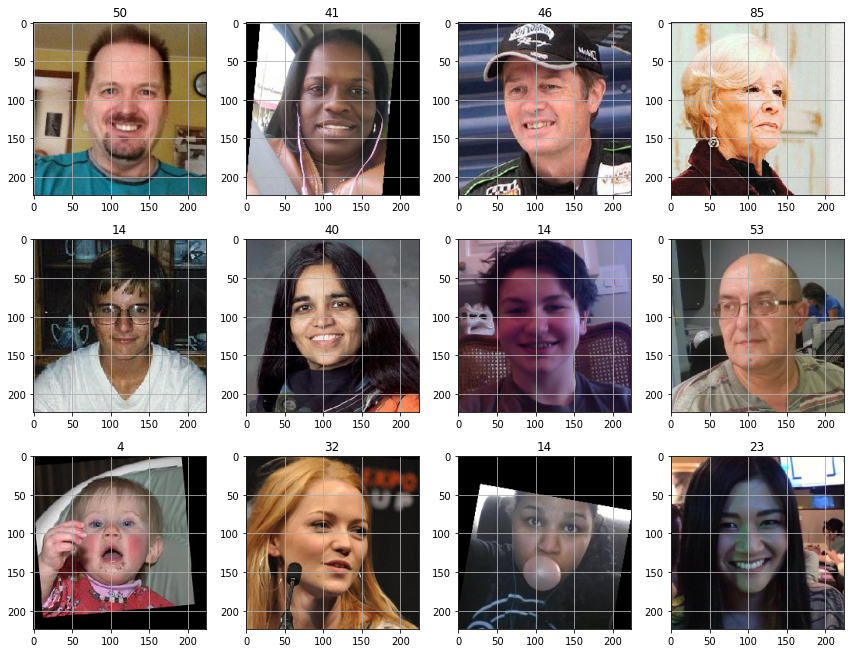

In [ ]:
fig = plt.figure(figsize=(12,24))
for i in range(12):
    fig.add_subplot(8,4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.grid(True)
fig.tight_layout()

Image Data set looks very diverse in terms of age, gender and origin which reinforces the model.
The background of the image is basiclly noise and does not contribute to the model for predicting the age of the character. but because we want the model to work on new data as well, we need it to learn what relevant and whats not.

##  <font color='#2F4F4F'>Step 4. Data Modeling</font>

In [ ]:
#Defining the  functions to train the model on the GPU platform and build a single

#initializing

def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split = 0.25,
        rescale = 1/255,
        horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224,244),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
        
    
    return train_gen_flow

In [ ]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split = 0.25,
        rescale = 1.0/255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='validation',
        seed = 12345)
    
    return test_gen_flow

In [ ]:
def create_model(input_shape=(224, 224, 3)):
    
    """
    It defines the model
    """
    backbone = ResNet50(weights='imagenet',
                       input_shape=input_shape,
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])
    
    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                  steps_per_epoch=None, validation_steps=None
               ):

    """
    Trains the model given the parameters
    """
    
    if step_per_epoch is None:
        step_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
             epochs=epochs,
             validation_data=test_data,
             batch_size=batch_size,
             steps_per_epoch=step_per_epoch,
             validation_steps=validation_steps,
             verbose=2)
    
    return model

In [ ]:
#Prepare the Script to Run on the GPU Platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

## <font color='#2F4F4F'>Step 5.Output</font>

Your observation goes here...

Output
Output from the GPU platform:

Using TensorFlow backend.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 178 steps, validate for 119 steps

Epoch 1/10

178/178 - 110s - loss: 198.6883 - mae: 10.5100 - val_loss: 514.1705 - val_mae: 17.6081
Epoch 2/10

178/178 - 38s - loss: 114.2769 - mae: 8.1078 - val_loss: 523.5679 - val_mae: 17.8237
Epoch 3/10

178/178 - 38s - loss: 90.5859 - mae: 7.2008 - val_loss: 473.4255 - val_mae: 16.6864
Epoch 4/10

178/178 - 37s - loss: 70.7201 - mae: 6.3631 - val_loss: 206.9530 - val_mae: 11.2742
Epoch 5/10

178/178 - 38s - loss: 54.5000 - mae: 5.5839 - val_loss: 101.7839 - val_mae: 7.4652
Epoch 6/10

178/178 - 37s - loss: 46.8688 - mae: 5.2320 - val_loss: 120.8870 - val_mae: 8.3172
Epoch 7/10

178/178 - 37s - loss: 43.4086 - mae: 5.0057 - val_loss: 81.2091 - val_mae: 6.7004
Epoch 8/10

178/178 - 38s - loss: 34.6991 - mae: 4.5056 - val_loss: 147.3814 - val_mae: 9.0652
Epoch 9/10

178/178 - 37s - loss: 28.8399 - mae: 4.1127 - val_loss: 83.4711 - val_mae: 6.7901
Epoch 10/10

178/178 - 37s - loss: 23.2032 - mae: 3.6992 - val_loss: 102.0375 - val_mae: 7.5944
119/119 - 9s - loss: 102.0375 - mae: 7.5944

Test MAE: 7.5944

## Conclusions

I used the ResNet50 neural network in order to predict age by face image, the traning set contains 5694 images and the tesing set contains 1897 images, my final MAE score is 7.5944

## <font color='#2F4F4F'>Step 6. Challenging our Solution</font>

#### a) Did we have the right question?
Yes we did

#### b) Did we have the right data?
Yes the data was right

#### c) What can be done to improve the solution?


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv("Training_set.csv")

#Checking data for null values
print(dataset_train.isnull().sum())

#loading required columns
training_set = dataset_train.iloc[:, 4:5].values

# Feature Scalingr̥
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
timesteps=10

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(timesteps, training_set.shape[0]):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))



# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)



# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2020
dataset_test = pd.read_csv("Testing_set.csv")
real_stock_price = dataset_test.iloc[:, 4:5].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(timesteps, timesteps+21):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()
© 2022 GitHub, Inc.
Terms
Privacy
Security
Status
Docs
Contact GitHub
Pricing
API
Training
Blog
About
